# Module Import

It is a good idea to first import `numpy`, `pandas`, and `matplotlib` since they are very handy for data wrangling and visualization.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# CART for Classification

## Dataset Import

We will demonstrate the use of CART for classification using the LendingClub loans dataset that we modeled using Logistic Regression earlier in the course.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/loans.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516 entries, 0 to 9515
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   default      9516 non-null   int64  
 1   installment  9516 non-null   int64  
 2   log_income   9516 non-null   float64
 3   fico_score   9516 non-null   int64  
 4   rev_balance  9516 non-null   float64
 5   inquiries    9516 non-null   int64  
 6   records      9516 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 520.5 KB


In [7]:
df.head(6)

,default,installment,log_income,fico_score,rev_balance,inquiries,records
0,0,829,4.93,737,28.85,0,0
1,0,228,4.81,707,33.62,0,0
2,0,367,4.51,682,3.51,1,0
3,0,162,4.93,712,33.67,1,0
4,0,103,4.91,667,4.74,0,0
5,0,125,5.17,727,50.81,0,0


In [8]:
df.default.value_counts(normalize=True)

0    0.840164
1    0.159836
Name: default, dtype: float64

In [9]:
df.describe()

,default,installment,log_income,fico_score,rev_balance,inquiries,records
count,9516.000000,9516.000000,9516.000000,9516.000000,9516.000000,9516.000000,9516.000000
mean,0.159836,320.142077,4.748656,710.841950,16.988948,1.572930,0.062211
std,0.366473,207.066550,0.265017,37.956246,33.721352,2.200329,0.262406
min,0.000000,16.000000,3.280000,612.000000,0.000000,0.000000,0.000000
25%,0.000000,164.000000,4.590000,682.000000,3.270000,0.000000,0.000000
50%,0.000000,269.500000,4.750000,707.000000,8.690000,1.000000,0.000000
75%,0.000000,435.250000,4.900000,737.000000,18.355000,2.000000,0.000000
max,1.000000,940.000000,6.310000,827.000000,1207.360000,33.000000,5.000000


## Training and Test Datasets

Let's split the data 70/30 into a training set (which we will use to build models) and a test set (on which we will evaluate any model we build).

In [10]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

In [11]:
X = df_train.copy()
y = X.pop('default')
X_test = df_test.copy()
y_test = X_test.pop('default')

In [12]:
X

,installment,log_income,fico_score,rev_balance,inquiries,records
3538,672,4.86,712,11.44,1,0
8464,361,4.90,672,25.88,2,0
3467,319,4.94,767,1.51,2,0
3979,329,4.95,667,11.27,0,0
5736,191,4.40,752,17.95,0,0
...,...,...,...,...,...,...
5734,243,5.18,682,0.63,1,0
5191,316,5.30,797,3.31,0,0
5390,199,4.77,702,7.28,0,0
860,569,4.81,667,11.29,1,0


## REFRESHER: Logistic Regression

We will build a logistic regression model on this dataset (like you did earlier in the course) so that we can compare it to the CART models we will be building later.

In [13]:
from statsmodels.formula.api import logit

formula="default ~ installment + log_income + fico_score + rev_balance + inquiries + records"
est = logit(formula=formula, data=df_train).fit()
print(est.summary())

Optimization terminated successfully.
         Current function value: 0.415078
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                 6661
Model:                          Logit   Df Residuals:                     6654
Method:                           MLE   Df Model:                            6
Date:                Mon, 16 Oct 2023   Pseudo R-squ.:                 0.05338
Time:                        18:06:06   Log-Likelihood:                -2764.8
converged:                       True   LL-Null:                       -2920.7
Covariance Type:            nonrobust   LLR p-value:                 2.415e-64
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       9.7634      0.994      9.824      0.000       7.816      11.711
installment     0.0013    

OK, we will come back to this model a bit later.

Next, we will define some 'helper' functions to calculate the profit per applicant under various scenarios.

## Helper Functions

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


def profit(y, y_pred, cutoff=0.5, verbose=False):
  '''
  Given a probability cutoff, predicted probabilities, and actual y values,
  calculates the profit per applicant
  '''
  will_default = np.where(y_pred >= cutoff, 1, 0)
  cm = confusion_matrix(y, will_default)
  if verbose:
    ConfusionMatrixDisplay.from_predictions(
        y,
        will_default,
        display_labels = ['No Default', 'Default']
        )
  cm_profit = 1000*cm[0,0]-5000*cm[1,0]
  return cm_profit/len(y)

def profit_table(y, y_pred, cutoffs=np.arange(0,1.01,0.1)):
  '''
  Given predicted probabilities, actual y values, and a set of cutoffs,
  calculates the profit per applicant for each cutoff
  and returns it in a two-column dataframe
  '''
  return pd.DataFrame({'cutoff': cutoffs,
                       'profit': [profit(y, y_pred, cutoff) for cutoff in cutoffs]})

def best_profit_and_cutoff(y, y_pred):
  '''
  Given predicted probabilities and actual y values, returns the optimal
  cutoff and optimal profit per applicant
  '''
  pf = profit_table(y, y_pred)
  idx = pf.profit.idxmax()
  return pf.loc[idx]

BTW, describing the function right below the `def` line, rather than as a comment above the function, has an interesting benefit.

## Building and Evaluating Classification Trees

### Build a Tree with Default Parameters

In [15]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [16]:
def viz_tree(tree, font=12, figsize=(16,10)):
  '''
  draws a classification tree
  '''
  plt.figure(figsize=figsize)  # set plot size (denoted in inches)
  _ = plot_tree(tree,
                feature_names=X.columns,
                filled=True,
                fontsize=font)

In [17]:
tree = DecisionTreeClassifier(random_state=42)

In [18]:
tree.fit(X,y)

DecisionTreeClassifier(random_state=42)

In [19]:
y_pred = tree.predict_proba(X_test)[:,1]
profit_table(y_test, y_pred)

,cutoff,profit
0,0.0,0.000000
1,0.1,74.255692
2,0.2,74.255692
3,0.3,74.255692
4,0.4,74.255692
5,0.5,74.255692
6,0.6,74.255692
7,0.7,74.255692
8,0.8,74.255692
9,0.9,74.255692


How does this compare to the best profit from the logistic regression model?

In [20]:
y_pred = est.predict(X_test)
profit_table(y_test, y_pred)

,cutoff,profit
0,0.0,0.000000
1,0.1,152.014011
2,0.2,153.415061
3,0.3,113.835377
4,0.4,57.793345
5,0.5,42.732049
6,0.6,32.574431
7,0.7,32.924694
8,0.8,32.924694
9,0.9,33.274956


Wow - logistic regression is way better!

How can we improve our CART model?

With the default settings of the hyperparameters, CART can overfit very easily.

One quick way to check for overfitting is to see how big the tree is.

In [21]:
tree.tree_.max_depth, tree.tree_.node_count

(35, 2515)

Wow, 2515 nodes! And 35 levels deep!

If we try to visualize this, we will probably crash the notebook so we won't try to.

To mitigate overfitting, let's prune the tree using ***cost-complexity pruning***.

### Cost complexity pruning

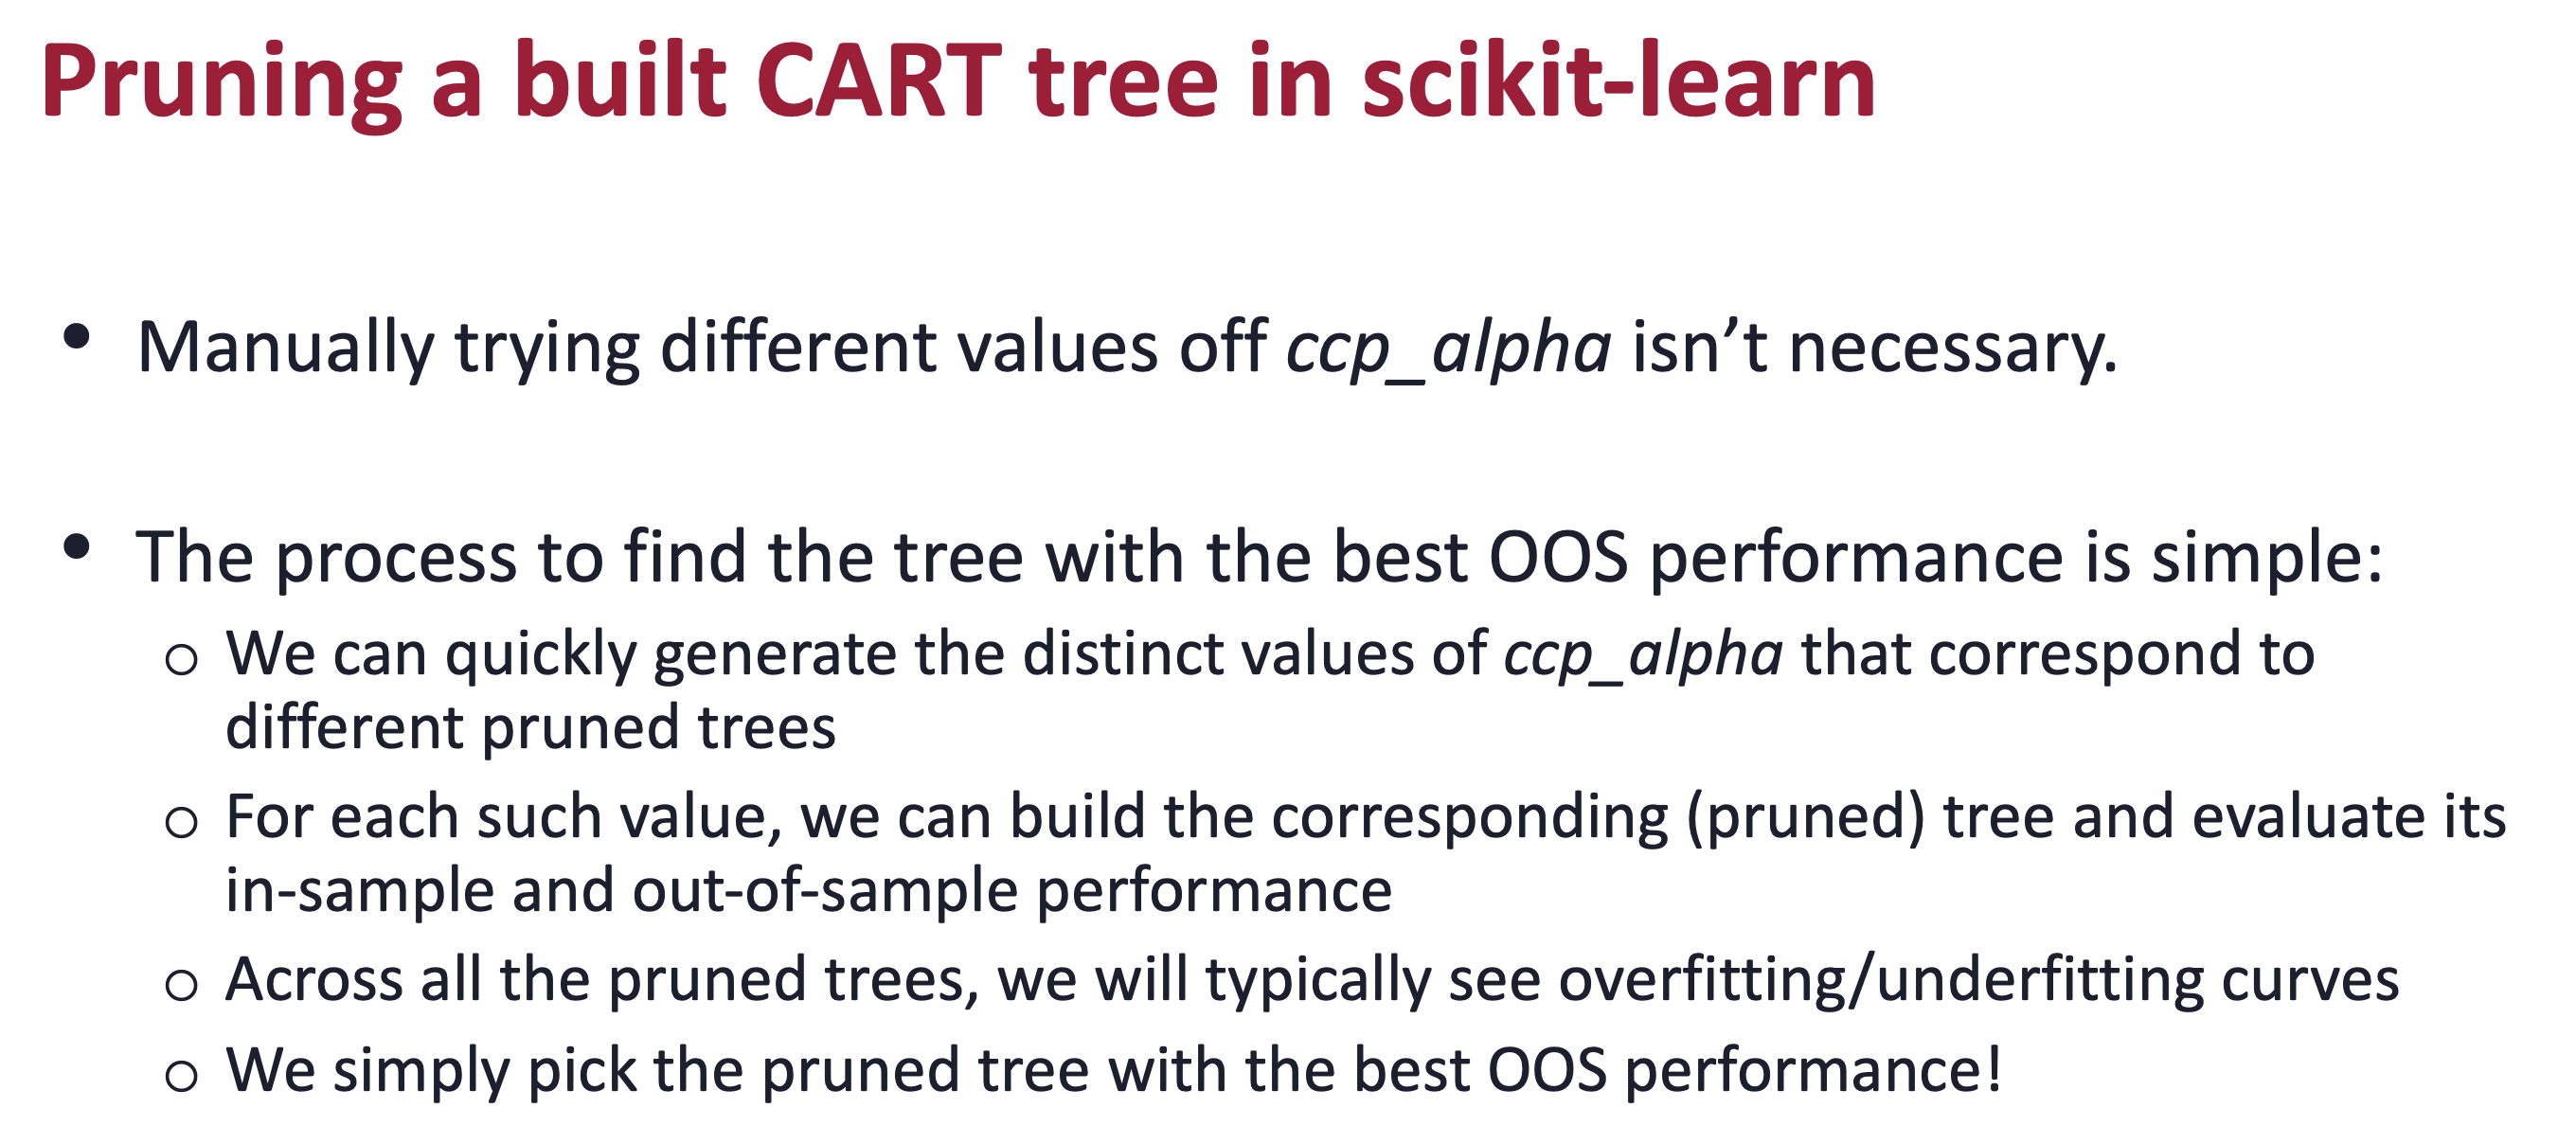

In [22]:
tree = DecisionTreeClassifier(random_state=42)

In [23]:
path = tree.cost_complexity_pruning_path(X,y)

In [24]:
alphas = path.ccp_alphas

In [25]:
trees = []
for alpha in alphas:
  tree = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
  tree.fit(X,y)
  trees.append(tree)

In [26]:
print(f"This process generated {len(trees)} trees.")

This process generated 436 trees.


Let's find the tree with the highest test profit.

In [27]:
def all_trees_profits_cutoffs(X,y):
  max_profit = []
  best_cutoff = []
  for tree in trees:
    y_pred = tree.predict_proba(X)[:,1]
    pf = best_profit_and_cutoff(y, y_pred)
    max_profit.append(pf['profit'])
    best_cutoff.append(pf['cutoff'])
  return max_profit, best_cutoff

In [28]:
train_profits, train_cutoffs = all_trees_profits_cutoffs(X,y)
test_profits, test_cutoffs = all_trees_profits_cutoffs(X_test,y_test)

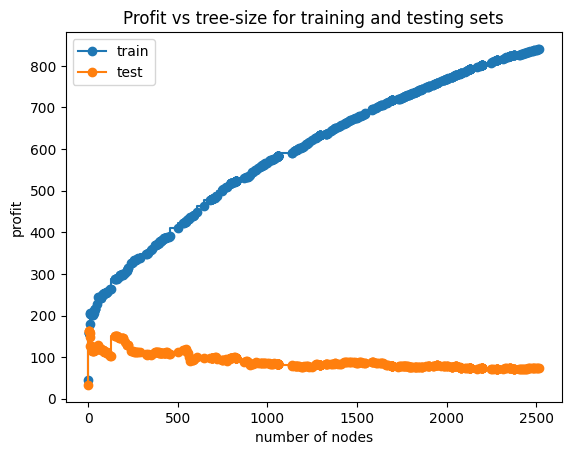

In [29]:
# https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html


node_counts = [tree.tree_.node_count for tree in trees]
depth = [tree.tree_.max_depth for tree in trees]


fig, ax = plt.subplots()
ax.set_xlabel("number of nodes")
ax.set_ylabel("profit")
ax.set_title("Profit vs tree-size for training and testing sets")
ax.plot(node_counts, train_profits, marker="o", label="train", drawstyle="steps-post")
ax.plot(node_counts, test_profits, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

Let's zoom in on the first section of the chart.

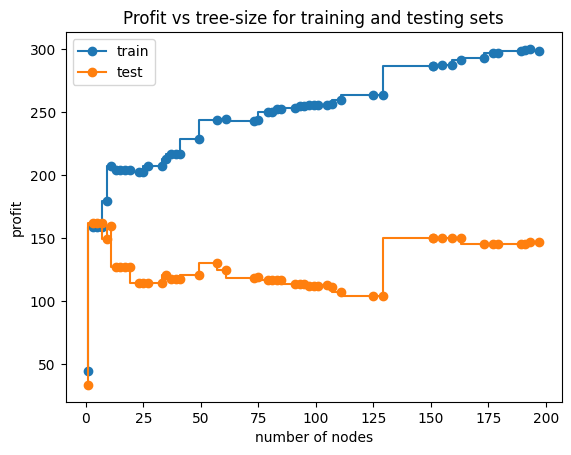

In [30]:
fig, ax = plt.subplots()
ax.set_xlabel("number of nodes")
ax.set_ylabel("profit")
ax.set_title("Profit vs tree-size for training and testing sets")
ax.plot(node_counts[-50:], train_profits[-50:], marker="o", label="train", drawstyle="steps-post")
ax.plot(node_counts[-50:], test_profits[-50:], marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [31]:
opt_idx = np.argmax(test_profits)

print(f"Profit of max-profit tree = ${max(test_profits):.2f}")
print(f"Size of max-profit tree = {node_counts[opt_idx]} nodes")
print(f"Optimal cutoff for chosen tree = {test_cutoffs[opt_idx]:.2f}")

Profit of max-profit tree = $161.82
Size of max-profit tree = 7 nodes
Optimal cutoff for chosen tree = 0.20


Great! This CART tree's profit is now higher than the profit from the logistic regression model!! And it is much smaller than the first tree we built.

Let's take a look at the tree.

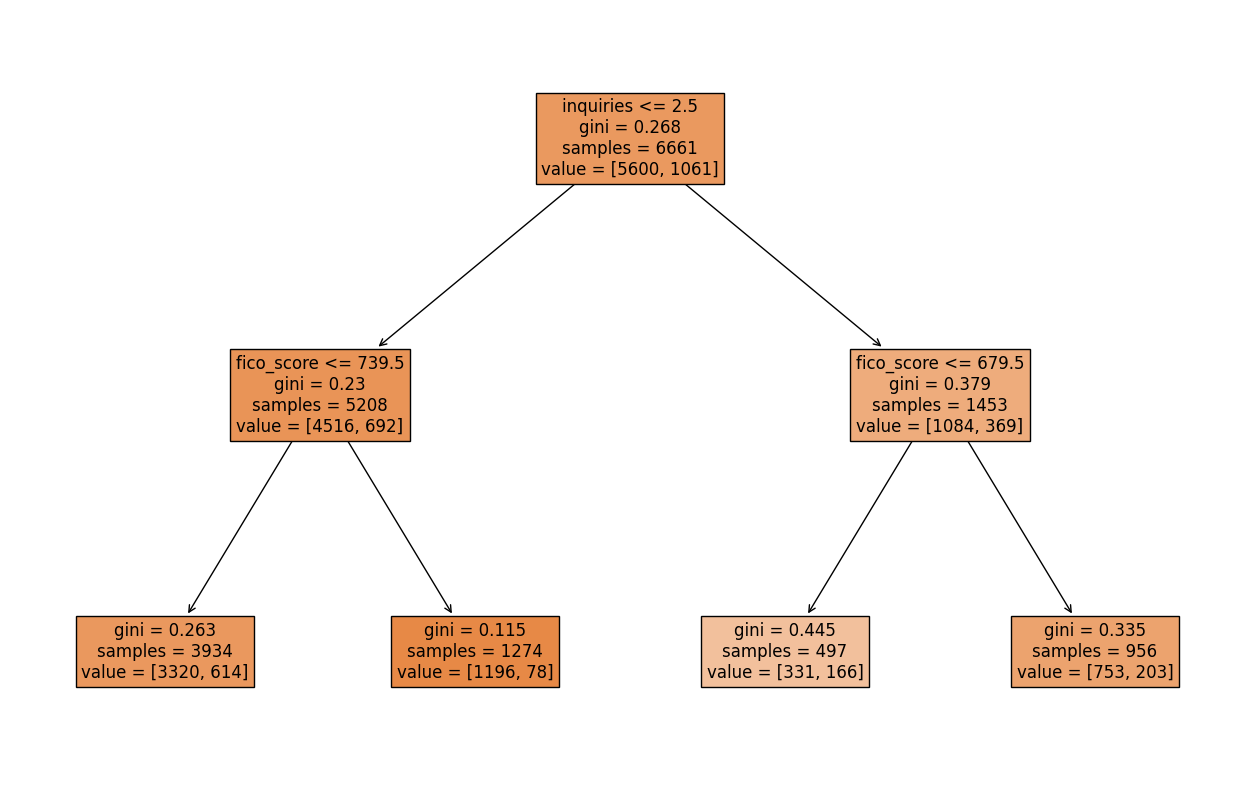

In [32]:
tree = trees[opt_idx]
viz_tree(tree)

# CART for Regression

### Dataset Import

We will demonstrate the use of CART for **regression** using the BlueBikes rentals dataset that we modeled using Linear Regression earlier in the course.

In [33]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rentals_weather.csv')

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8603 entries, 0 to 8602
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rentals        8603 non-null   int64  
 1   month          8603 non-null   int64  
 2   day            8603 non-null   int64  
 3   hour           8603 non-null   int64  
 4   day_of_week    8603 non-null   object 
 5   weekend        8603 non-null   int64  
 6   temp           8603 non-null   int64  
 7   temp_wb        8603 non-null   int64  
 8   rel_humidity   8603 non-null   int64  
 9   windspeed      8603 non-null   int64  
 10  precipitation  8603 non-null   float64
dtypes: float64(1), int64(9), object(1)
memory usage: 739.4+ KB


In [35]:
df.head()

,rentals,month,day,hour,day_of_week,weekend,temp,temp_wb,rel_humidity,windspeed,precipitation
0,4,1,1,0,Mon,0,2,0,59,16,0.0
1,6,1,1,1,Mon,0,1,0,59,11,0.0
2,6,1,1,2,Mon,0,1,-1,54,21,0.0
3,1,1,1,5,Mon,0,0,-2,54,18,0.0
4,3,1,1,6,Mon,0,0,-2,54,15,0.0


As we did in Linear Regression, we will first tell Pandas which variables should be treated as categorical.

In [36]:
categoricals = ['month', 'day', 'hour', 'day_of_week', 'weekend']
df[categoricals] = df[categoricals].astype('category')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8603 entries, 0 to 8602
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   rentals        8603 non-null   int64   
 1   month          8603 non-null   category
 2   day            8603 non-null   category
 3   hour           8603 non-null   category
 4   day_of_week    8603 non-null   category
 5   weekend        8603 non-null   category
 6   temp           8603 non-null   int64   
 7   temp_wb        8603 non-null   int64   
 8   rel_humidity   8603 non-null   int64   
 9   windspeed      8603 non-null   int64   
 10  precipitation  8603 non-null   float64 
dtypes: category(5), float64(1), int64(5)
memory usage: 448.3 KB


## Training and Test Datasets

Let's split the data 70/30 into a training set (which we will use to build models) and a test set (on which we will evaluate any model we build).

In [38]:
df_train, df_test = train_test_split(df, test_size=0.3, shuffle=True, random_state=42)

In [39]:
X = df_train.copy()
y = X.pop('rentals')
X_test = df_test.copy()
y_test = X_test.pop('rentals')

## REFRESHER: Linear Regression

In [40]:
my_formula = 'rentals ~ ' + '+'.join(df.columns[1:])

In [41]:
from statsmodels.formula.api import ols
est = ols(formula = my_formula, data=df_train).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                rentals   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     177.1
Date:                Mon, 16 Oct 2023   Prob (F-statistic):               0.00
Time:                        18:07:39   Log-Likelihood:                -37739.
No. Observations:                6022   AIC:                         7.563e+04
Df Residuals:                    5946   BIC:                         7.614e+04
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -163.4356     23

## Helper Functions

In [42]:
def OSR2(y_pred, y_true, training_mean):
  '''
  Calculates out-of-sample R-squared
  '''
  baseline_error = np.sum(np.square((training_mean - y_true)))
  model_error = np.sum(np.square((y_pred - y_true)))
  return 1.0 - model_error/baseline_error

In [43]:
OSR2(est.predict(X_test), y_test, y.mean())

0.6832349952617289

The OSR2 for the linear regression model is 0.68.

## Building and Evaluating Regression Trees

### Build a Tree with Default Parameters

In [44]:
from sklearn.tree import DecisionTreeRegressor

In [45]:
tree = DecisionTreeRegressor(random_state=42)

We need to one-hot encode the categorical variables ourselves before feeding it to CART (in contrast, for linear regression, we merely had to indicate which variables were categorical).

The Pandas `get_dummies` function make this easy.

In [46]:
X.head()

,month,day,hour,day_of_week,weekend,temp,temp_wb,rel_humidity,windspeed,precipitation
5156,8,9,14,Thu,0,84,74,61,10,0.00
6290,9,26,1,Wed,0,70,68,90,5,0.00
2646,4,26,19,Thu,0,57,49,53,13,0.00
439,1,21,16,Sun,1,46,39,51,5,0.00
1379,3,2,16,Fri,0,41,39,86,46,0.03


In [47]:
X = pd.get_dummies(X, columns = categoricals)
X_test = pd.get_dummies(X_test, columns = categoricals)

In [48]:
X.head()

,temp,temp_wb,rel_humidity,windspeed,precipitation,month_1,month_2,month_3,month_4,month_5,...,hour_23,day_of_week_Fri,day_of_week_Mon,day_of_week_Sat,day_of_week_Sun,day_of_week_Thu,day_of_week_Tue,day_of_week_Wed,weekend_0,weekend_1
5156,84,74,61,10,0.00,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
6290,70,68,90,5,0.00,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2646,57,49,53,13,0.00,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
439,46,39,51,5,0.00,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1379,41,39,86,46,0.03,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0


Above, check out how the `get_dummies` function has transformed X.

Let's build a CART tree with the default settings.

In [49]:
tree.fit(X,y)

DecisionTreeRegressor(random_state=42)

How well does it do on the training set?

In [50]:
OSR2(tree.predict(X), y, y.mean())

1.0

Whoa! An R2 of 100%!!

This is a sign of overfitting.

Let's see how big this tree is.

In [51]:
tree.tree_.node_count, tree.tree_.max_depth

(11301, 47)

HUGE!

We definitely need to regularize it with cost-complexity pruning. Before we do that, let's see how it does on the test set.

In [52]:
OSR2(tree.predict(X_test), y_test, y.mean())

0.7824430330733544

Hmm, better than linear regression.


### Cost complexity pruning

In [53]:
tree = DecisionTreeRegressor(random_state=42)

In [54]:
path = tree.cost_complexity_pruning_path(X,y)

In [55]:
alphas = path.ccp_alphas

In [56]:
len(alphas)

5186

That's a lot of trees! In the interest of time, we will generate about ~50 trees, evenly sampled from this group.

In [57]:
alphas_small = alphas[::100]
alphas_small = alphas_small[::-1]

In [58]:
r2_all = []
osr2_all = []
node_counts = []

for alpha in alphas_small:
  tree = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha)
  tree.fit(X,y)
  y_pred = tree.predict(X)
  r2_all.append(OSR2(y_pred, y, y.mean()))
  y_pred = tree.predict(X_test)
  osr2_all.append(OSR2(y_pred, y_test, y.mean()))
  node_counts.append(tree.tree_.node_count)

Text(0.5, 1.0, 'Prediction quality vs tree size')

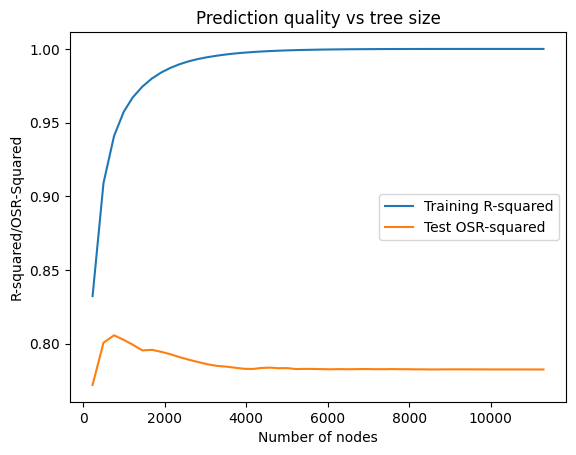

In [59]:
plt.plot(node_counts, r2_all, label='Training R-squared')
plt.plot(node_counts, osr2_all, label='Test OSR-squared')
plt.legend()
plt.xlabel('Number of nodes')
plt.ylabel('R-squared/OSR-Squared')
plt.title('Prediction quality vs tree size')

Text(0.5, 1.0, 'Prediction quality vs tree size')

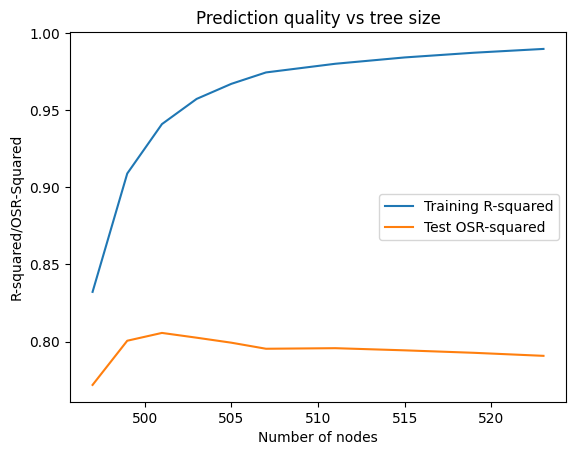

In [86]:
plt.plot(node_counts[:10], r2_all[:10], label='Training R-squared')
plt.plot(node_counts[:10], osr2_all[:10], label='Test OSR-squared')
plt.legend()
plt.xlabel('Number of nodes')
plt.ylabel('R-squared/OSR-Squared')
plt.title('Prediction quality vs tree size')

Clear overfitting. As the tree size (i.e., number of nodes) increases, the training set R2 gets better but the test set OSR2 peaks around 0.8 and then decreases as overfitting kicks in.

Let's extract the tree corresponding to the best OSR2.

In [60]:
opt_idx = np.argmax(osr2_all)

In [61]:
 tree = DecisionTreeRegressor(random_state=42, ccp_alpha=alphas_small[opt_idx])
 tree.fit(X,y)

DecisionTreeRegressor(ccp_alpha=9.300806457131927, random_state=42)

In [62]:
tree.tree_.node_count, tree.tree_.max_depth

(753, 30)

Still very big but maybe not huge?

Let's try to visualize it.

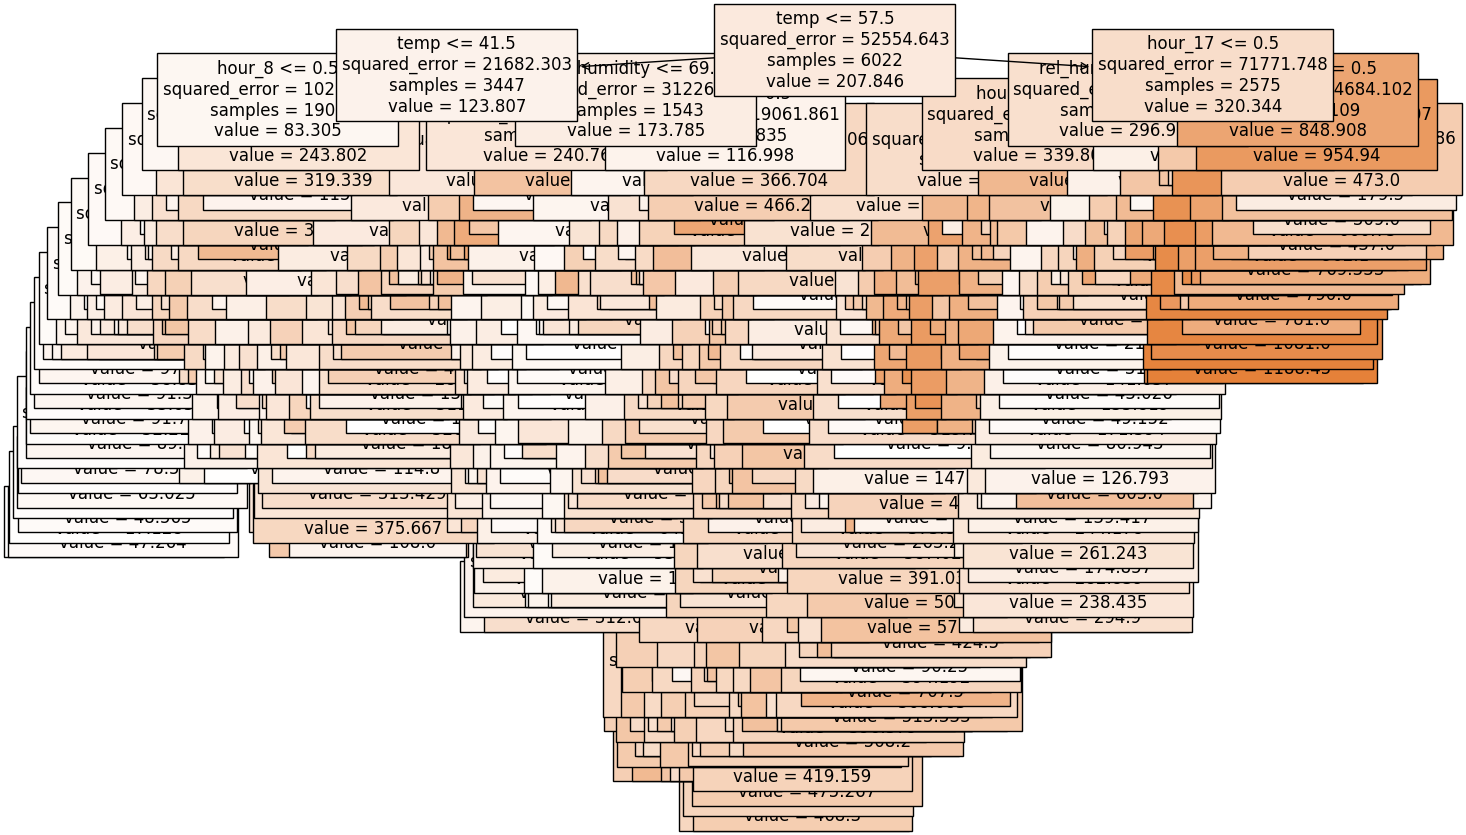

In [120]:
viz_tree(tree)

Let's confirm that this tree's OSR2 is indeed around 0.8

In [63]:
OSR2(tree.predict(X_test), y_test, y.mean())

0.8056467590667243

**OSR2 Summary**

Linear Regression:        0.68

Full tree before pruning: 0.78

Pruned tree:              0.81

##Searching a better ccp Alpha

In [83]:
alphas_zoom = alphas[(52-opt_idx-1)*100-100:(52-opt_idx-1)*100+100][::-1]

In [84]:
r2_zoom = []
osr2_zoom = []
node_counts = []

for alpha in alphas_zoom:
  tree = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha)
  tree.fit(X,y)
  y_pred = tree.predict(X)
  r2_zoom.append(OSR2(y_pred, y, y.mean()))
  y_pred = tree.predict(X_test)
  osr2_zoom.append(OSR2(y_pred, y_test, y.mean()))
  node_counts.append(tree.tree_.node_count)

In [87]:
opt_idx_zoom

184

In [88]:
opt_idx_zoom = np.argmax(osr2_zoom)
tree_zoom = DecisionTreeRegressor(random_state=42, ccp_alpha=alphas_zoom[opt_idx_zoom])
tree_zoom.fit(X,y)

DecisionTreeRegressor(ccp_alpha=16.135283062632762, random_state=42)

In [89]:
tree_zoom.tree_.node_count, tree_zoom.tree_.max_depth

(541, 28)

In [90]:
OSR2(tree_zoom.predict(X_test), y_test, y.mean())

0.8095955795763795

Text(0.5, 1.0, 'Prediction quality vs tree size')

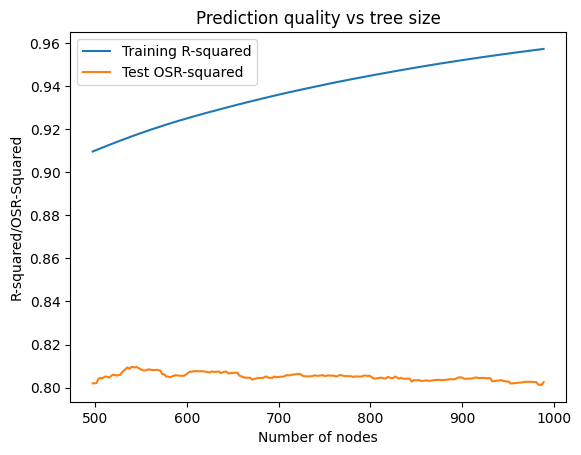

In [91]:
plt.plot(node_counts, r2_zoom, label='Training R-squared')
plt.plot(node_counts, osr2_zoom, label='Test OSR-squared')
plt.legend()
plt.xlabel('Number of nodes')
plt.ylabel('R-squared/OSR-Squared')
plt.title('Prediction quality vs tree size')